# Network analysis of RNA edited genes adding RNAseq LFC


----------------------

Author: Brin Rosenthal

Date: July 18, 2018

----------------------

<a id='toc'></a>
## Table of Contents
1. [Background](#background)
2. [Import packages](#import)
3. [Define Analysis Preferences](#pref)
3. [Load Networks](#load)
4. [Run Heat Propagation](#heat)
5. [Clustering](#cluster)

## Background
<a id='background'></a>

## Import packages
<a id='import'></a>

In [1]:
import sys
code_path = '/Users/brin/network_bio_toolkit/network_bio_toolkit'
sys.path.append(code_path)

import Heat2
import imp

imp.reload(Heat2)

<module 'Heat2' from '/Users/brin/network_bio_toolkit/network_bio_toolkit/Heat2.pyc'>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import random

import community

from scipy.stats import mannwhitneyu

import mygene
mg = mygene.MyGeneInfo()

# latex rendering of text in graphs
import matplotlib as mpl
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

sns.set_style('white')


import visJS2jupyter.visJS_module
import visJS2jupyter.visualizations



% matplotlib inline

## Define Analysis Preferences
<a id='pref'></a>

In [3]:
heat = Heat2.Heat(gene_type = 'symbol', species = 'human')

## Load Networks
<a id='load'></a>

1. Load edited gene list
2. Load STRING background network

In [8]:
focal_comp='AMLvsMF'

In [9]:
# load DEG file
#DEG_filename = "../../DEG_databases/DE_CoeffspaceFlight - groundControl_glds48_20180312.csv"  

if focal_comp=='AMLvsAN':
    DEG_filename = '../data/DE_genes/Limma_DE_AgedBMvsAML_Prog_Holm_Jamieson_RNASeq_TCW.csv'
elif focal_comp=='MFvsAN':
    DEG_filename = '../data/DE_genes/Limma_DE_AgedBMvsMF_Prog_Holm_Jamieson_RNASeq_TCW.csv'
elif focal_comp=='AMLvsMF':
    DEG_filename = '../data/DE_genes/Limma_DE_AMLvsMF_Prog_Holm_Jamieson_RNASeq_TCW.csv'
heat.create_DEG_list(DEG_filename, p_value_filter = 0.05, sep = ',',p_value_or_adj='adj')

print('Number of seed genes\'s: ' + str(len(heat.DEG_list)))

Number of seed genes's: 668


In [71]:
# overwrite the 'DEG_list' with the seed genes we want to use-- RNA edited genes
#seed_gene_filename = '../data/rna_editing/differentially_edited_genes_progenitors06132018.txt'


seed_gene_filename = '../data/rna_editing/differentially_edited_genes_'+focal_comp+'_progenitors08102018.txt'
rna_edited_df = pd.read_csv(seed_gene_filename,sep='\t')


heat.DEG_list = rna_edited_df['Gene'].tolist()
print(len(rna_edited_df))

1434


In [60]:
rna_edited_df.head()

,p.value,Gene,n_MF,n_AML,n_samples_MF,n_samples_AML,n_possible_sites_MF,n_possible_sites_AML,diff,diff_norm
0,2.190000e-26,UBE2E2,1,17,22,3,374,51,-16,-0.330660
1,3.010000e-12,ACAP2,25,21,22,3,792,108,4,-0.162879
2,5.810000e-12,RHOA,37,25,22,3,880,120,12,-0.166288
3,1.560000e-11,DGKD,0,7,22,3,132,18,-7,-0.388889
4,4.710000e-11,AGO4,43,26,22,3,1012,138,17,-0.145916


In [61]:
# for g in heat.DEG_list:
#     print(g)

In [62]:
len(heat.DEG_list)

50

In [10]:
# load our saved network from ndex rather than loading it ourselves
# equivalent to heat.load_STRING_links('../../background_networks/10090.protein.links.v10.5.txt', confidence_filter = 700)
heat.load_ndex_from_server(UUID = '7689335d-6fef-11e8-a4bf-0ac135e8bacf', relabel_node_field = 'name')

print('\nNumber of interactions: ' + str(len(list(heat.DG_universe.edges()))))
print('Number of nodes: '+str(len(list(heat.DG_universe.nodes()))))


Number of interactions: 328968


In [11]:
saved_DG_universe = heat.DG_universe
heat.DG_universe = saved_DG_universe

In [72]:
len(np.intersect1d(heat.DEG_list,heat.DG_universe.nodes()))

972

## Localization ##

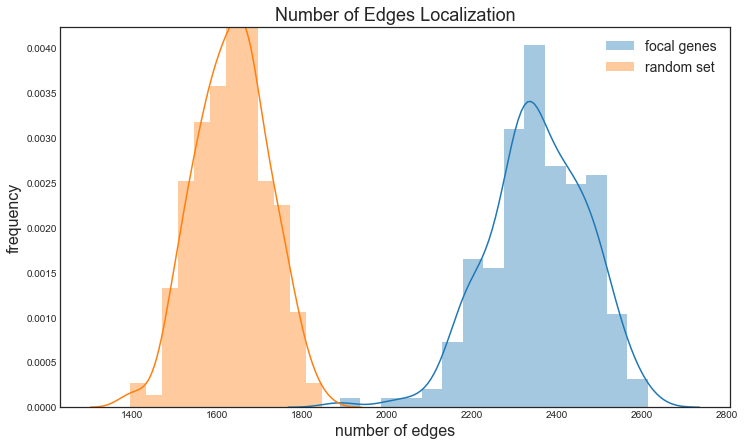

In [12]:
numedges_list, numedges_rand, LCC_list, LCC_rand = heat.localization(num_reps = 200, 
                                                                     sample_frac = 0.8, 
                                                                     method = 'numedges', 
                                                                     plot = True)



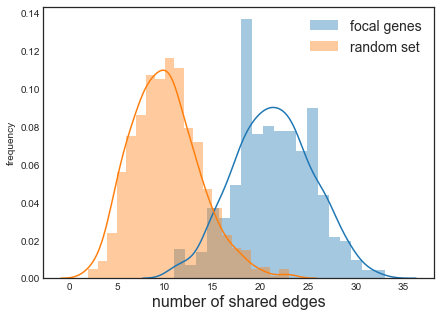

In [67]:
plt.figure(figsize=(7,5))
sns.distplot(numedges_list,label='focal genes')
sns.distplot(numedges_rand,label='random set')
plt.legend(loc='best',fontsize=14)
plt.xlabel('number of shared edges',fontsize=16)
plt.ylabel('frequency')

plt.savefig('../figures/rna_editing_localization_num_edges.png',dpi=300,bbox_inches='tight')

7.170476344353638e-06


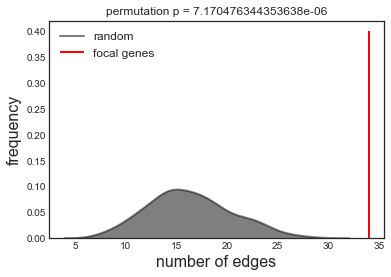

In [10]:
# test out plotting parameters with a smaller num_reps first.
numedges_list, numedges_rand, LCC_list, LCC_rand = heat.localization_full(num_reps = 200, 
                                                                          method = 'numedges', 
                                                                          label = 'focal genes',
                                                                          line_height = 0.4,
                                                                          legend_loc = 'upper left')

## Set up network propagation
<a id='heat'></a>

In [12]:
Wprime = heat.normalized_adj_matrix() # optional. Saves time to do it once here.

In [13]:
saved_Wprime = heat.Wprime
heat.Wprime = saved_Wprime

## Network prop and Clustering 
<a id='cluster'></a>

Parameter information:
- **G_DEG**: background network filtered by DEG list, output of load_STRING_to_digraph
- **DG_universe**: full background network, output of create_graph.load_STRING_to_digraph 
- **seed_nodes**: list of DEG's, output of create_graph.create_DEG_list
- **Wprime**: will calculate automatically of not specified, output of visualizations.normalized_adj_matrix
- **num_top_genes**: number of genes to display in the output graph
- **cluster_size_cut_off**: color clusters below this threshhold grey
- **remove_stray_nodes**: remove custers below the cluster size cut off
- **r**: increases spacing between clusters. recommended number between 0.5 and 4.0
- **x_offset**: modify if some clusters are overlapping. Extra helpful when x_offset != y_offset
- **y_offset**: modify if some clusters are overlapping. Extra helpful when x_offset != y_offset
- **node_spacing**: recommended number between 500 and 2000
- **node_size_multiplier**: as you scale node_spacing, scale this number. Recommended number between 5 and 25
- **physics_enabled**: Nodes will bounce aroound when you click and drag them. Only set to True when number of nodes is 200 or less
- **node_font_size**: as you scale node_spacing, scale this number. Recommended number between 20 and 50
- **graph_id**: Allows rendering of multiple graphs in one notebook. Just make sure each graph has a unique id. 

In [47]:
topN= 500 #len(heat.DEG_list)
if topN<500: # make minimum value 500
    topN=500

In [48]:
heat.draw_clustering(rad_positions = False,
                k = 0.3,
                largest_connected_component = True,
                num_top_genes = topN,
                cluster_size_cut_off = 5,
                remove_stray_nodes = True,
                node_spacing = 2000,
                node_size_multiplier = 6,
                physics_enabled = False,
                node_font_size = 30,
                graph_id = 2,
                edge_width = 2,
                edge_smooth_enabled = True,
                edge_smooth_type = 'bezier',
                hover = False,
                hover_connected_edges = False
               )

In [49]:
heat.draw_clustering(rad_positions = False,
                k = 0.3,
                largest_connected_component = True,
                num_top_genes = topN,
                cluster_size_cut_off = 5,
                remove_stray_nodes = True,
                node_spacing = 2000,
                node_size_multiplier = 6,
                physics_enabled = False,
                node_font_size = 30,
                graph_id = 3,
                edge_width = 2,
                edge_smooth_enabled = True,
                edge_smooth_type = 'bezier',
                hover = False,
                color_lfc = True,
                vmin=-2,vmax=2,
                hover_connected_edges = False,
                     export_network=True,export_file='RNA_editing_'+str(topN)+'netprop_'+focal_comp+'.json'
               )

446
446


In [50]:
heat.write_cluster_table('RNA_editing_'+str(topN)+'netprop_'+focal_comp+'.csv') 

# found a problem with this function.  Needs to write results for all genes in the subgraph, even if they don't have 
# LFC/pvals (see Heat2.py line 633-643)

In [51]:
len(heat.node_to_cluster)

446

In [52]:
heat.node_to_cluster.keys()

[u'BPTF',
 u'SMARCC1',
 u'NELFA',
 u'PSPC1',
 u'NDUFB1',
 u'SRSF11',
 u'CCT4',
 u'CCNT1',
 u'GNB4',
 u'EFTUD2',
 u'OGDH',
 u'ZNF708',
 u'ZNF701',
 u'TAOK1',
 u'RNF114',
 u'PRIM1',
 u'SPTLC1',
 u'NUP214',
 u'CUL5',
 u'WEE1',
 u'IRAK4',
 u'SUMO2',
 u'ZNF43',
 u'NUP98',
 u'WNK1',
 u'NUP93',
 u'USP39',
 u'STK4',
 u'NUPL2',
 u'GMPS',
 u'KAT8',
 u'GTF2F1',
 u'SNRPD1',
 u'SNAP23',
 u'SYAP1',
 u'DDX46',
 u'PTEN',
 u'EPC1',
 u'COPB1',
 u'KLC1',
 u'FDX1',
 u'CEP78',
 u'CTCF',
 u'TSG101',
 u'RPS27A',
 u'MED25',
 u'SIRT1',
 u'POLR1D',
 u'POLR1E',
 u'MATR3',
 u'GNPNAT1',
 u'XRCC2',
 u'ACADM',
 u'XRCC6',
 u'XPO1',
 u'SRSF4',
 u'CCT8',
 u'SMURF2',
 u'PPM1B',
 u'NONO',
 u'VPS37B',
 u'NARS',
 u'RNF130',
 u'PAICS',
 u'PDPR',
 u'YARS',
 u'WSB1',
 u'NF1',
 u'ZNF431',
 u'RNF138',
 u'CHEK2',
 u'CHEK1',
 u'POLA2',
 u'SAE1',
 u'GSPT1',
 u'XPOT',
 u'SENP6',
 u'CHUK',
 u'HERC1',
 u'PSMB7',
 u'SMG6',
 u'UBA2',
 u'HIST2H3A',
 u'GART',
 u'ANAPC5',
 u'ANAPC7',
 u'ZNF611',
 u'GINS1',
 u'ZNRF1',
 u'CSNK1A1',
 u'GINS4

In [53]:
len(heat.node_to_pvalue)

11767

# Gprofiler annotation of clusters

In [54]:
from gprofiler import GProfiler
gp = GProfiler("MyToolName/0.1")

In [55]:
partition = pd.Series(heat.node_to_cluster)
partition.value_counts()

7     67
1     62
0     62
8     57
3     56
6     47
4     42
2     34
5     12
9      4
10     3
dtype: int64

In [56]:
import os

savedir = 'gprofile_clusters_top'+str(topN)+'_'+focal_comp
if not os.path.isdir(savedir):
    os.mkdir(savedir)


for focal_cluster in partition.value_counts().index.tolist():
    print(focal_cluster)
    focal_genes = partition[partition==focal_cluster].index.tolist()

    gp_results = pd.DataFrame(gp.gprofile(focal_genes,custom_bg = partition.index.tolist(),correction_method=gp.THR_FDR))

    gp_results.columns = ["query.number", "significant", "p.value", "term.size",
                          "query.size", "overlap.size", "recall", "precision",
                          "term.id", "domain", "subgraph.number", "term.name",
                          "relative.depth", "intersection"]
    print(gp_results[['p.value','term.id','term.name']].head())
    
    writer = pd.ExcelWriter(savedir+'/cluster_'+str(focal_cluster)+'.xlsx')
    gp_results.to_excel(writer)
    writer.save()

#gp_results = pd.DataFrame(gp.gprofile(focal_genes,correction_method=gp.THR_FDR))

7
        p.value             term.id  \
0  1.820000e-13  REAC:R-HSA-5653656   
1  1.820000e-13   REAC:R-HSA-199991   
2  1.080000e-12          GO:0016192   
3  9.020000e-09  REAC:R-HSA-6811442   
4  1.070000e-08          GO:0048193   

                                        term.name  
0                      Vesicle-mediated transport  
1                            Membrane Trafficking  
2                      vesicle-mediated transport  
3  Intra-Golgi and retrograde Golgi-to-ER traffic  
4                         Golgi vesicle transport  
1
        p.value           term.id                                 term.name
0  5.520000e-15  REAC:R-HSA-73894                                DNA Repair
1  1.430000e-14        GO:0006259                     DNA metabolic process
2  5.860000e-14        GO:0006281                                DNA repair
3  7.350000e-14        GO:0006260                           DNA replication
4  2.630000e-13        GO:0006974  cellular response to DNA damage st

In [23]:
focal_cluster=1
focal_genes = partition[partition==focal_cluster].index.tolist()

for g in focal_genes:

    print(g)

AKAP9
ANKHD1
ARFGAP2
CCNB1
CDC42
CENPC
CENPN
CENPP
CEP78
CLASP2
CLIP1
COG7
COPB1
COPE
CSE1L
CSNK1D
DYNC1H1
ENSA
FOXO1
GEMIN2
HAUS2
HSPA9
IFT140
KIF2A
KLC1
KMT2E
KNTC1
MAP2K1
MAP3K2
MASTL
MIS12
MIS18BP1
MOB1B
NDC80
NPM1
NUP153
NUP155
NUP160
NUP188
NUP214
NUP43
NUP93
NUP98
NUPL2
NXF1
PAFAH1B1
PCM1
PDS5A
PHAX
PML
PPP1CB
PPP2R1A
PRC1
PRKAR2A
RAF1
RANBP2
RAP1B
RINT1
SDCCAG8
SEC31A
SMC5
SPC24
STAG2
STK38
STK4
STX12
STX2
STX5
STX8
TAOK1
THOC5
TMEM170A
TMEM67
VPS53
VTI1A
XPO1
XPOT
YWHAE
YWHAZ
ZWINT
